In [1]:
import os
import sys

prev_dir = os.path.dirname(os.getcwd())
if prev_dir not in sys.path: sys.path.append(prev_dir)

import collections
from dataclasses import dataclass
import itertools
import traceback
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import warnings

import const
from data_gen.density import ExpGLMDensity, ExpDensity, BetaDensity, NonLDSDensity
from data_gen.phi_embedding import ConstPhiEmbedding, LDSPhiEmbedding, PhiEmbedding
from estimation.score_matching import ScoreMatching
import hamiltorch
import numpy as np
import matplotlib.axes as axes
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import seaborn as sns
import torch
from tqdm import tqdm
import utils
import utils_1d_densities

In [2]:
T = Union[np.ndarray, torch.Tensor]
SEED = 0

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
##### modified functions from utils_1d_densities

@dataclass
class Density1D:
    name: str
    x: np.ndarray
    prob: np.ndarray
    plot_name: str


def get_1d_densities(
    exp_glm_density: ExpGLMDensity,
    W: torch.Tensor,
    phi: torch.Tensor,
    n_points_eval: int,
    samples: torch.Tensor,
    sm_estimator: ScoreMatching,
    SM_lam: float = 0.01,
    MLE_use_normal_dist: bool = False,
    MLE_all_priors_same: bool = False,
    MLE_W0 = None,
) -> List[Density1D]:
    '''
    Args:
        W: shape (d_psi, d_phi)
        phi: shape (m, d_phi)
        samples: shape (m, n, d_s)
    '''
    assert W.shape[1] == phi.shape[1]
    assert phi.shape[0] == samples.shape[0]
    assert samples.shape[2] == exp_glm_density.d_s

    m, n, d_s = samples.shape
    d_phi = phi.shape[1]
    N = n_points_eval
    densities = []

    # Points to evaluate density at
    # TODO define this range based on mean and 3*stdev of density?
    support_lo = -5 if np.isinf(exp_glm_density.SUPPORT_LO) and (exp_glm_density.SUPPORT_LO < 0) else exp_glm_density.SUPPORT_LO
    support_hi = 5 if np.isinf(exp_glm_density.SUPPORT_HI) and (exp_glm_density.SUPPORT_HI > 0) else exp_glm_density.SUPPORT_HI
    x = np.linspace(support_lo, support_hi, N).reshape((-1, 1)) # shape (N, d_s)

    # True density
    print('Calculating true density...')
    try:
        prob = exp_glm_density.density(x, W, phi[:1]) # shape (N, 1)
        true_density = Density1D(
            name='true',
            x=x[:, 0],
            prob=utils.to_numpy(prob[:, 0]),
            plot_name='Ground truth density',
        )
        densities.append(true_density)
    except ValueError as e:
        warnings.warn(traceback.format_exc())

    print('Calculating density using W_SM...')
    # Get W estimate using Score Matching
    try:
        # Collapse the 3d tensor samples
        samples_exp = samples.detach().reshape((-1, d_s)) # shape (m*n, d_s)

        # Repeat each phi n times in the 2d tensor
        phi_exp = phi.unsqueeze(1).expand(-1, n, -1).reshape((-1, d_phi)) # shape (m*n, d_phi)

        W_SM = sm_estimator.W_estimate(
            samples_exp, phi_exp, lam=SM_lam, return_Vb_estimates=False
        )
        prob = exp_glm_density.density(x, W_SM, phi[:1]) # shape (N, 1)
        sm_density = Density1D(
            name='SM',
            x=x[:, 0],
            prob=utils.to_numpy(prob[:, 0]),
            plot_name='Density with $\\hat{\\theta}_{SM}$'
        )
        densities.append(sm_density)

        tvd_SM = utils.tvd(true_density.x, true_density.prob, sm_density.prob)
        print(f'tvd_SM: {tvd_SM:0.5e}')
    except ValueError as e:
        warnings.warn('Score Matching assumptions are not met.\n' + traceback.format_exc())
        
    print('Calculating density using actual W_MLE...')
    # Get W estimate using actual MLE
    try:
        W_MLE = exp_glm_density.W_MLE_estimate(samples, phi, W0=MLE_W0) # shape (d_psi, d_phi)

        prob = exp_glm_density.density(x, W_MLE, phi[:1]) # shape (N, 1)
        plot_name = 'Density with $\\hat{\\theta}_{MLE}$'
        mle_density = Density1D(
            name='MLE',
            x=x[:, 0],
            prob=utils.to_numpy(prob[:, 0]),
            plot_name=plot_name
        )
        densities.append(mle_density)

        tvd_MLE = utils.tvd(true_density.x, true_density.prob, mle_density.prob)
        print(f'tvd_actual_MLE: {tvd_MLE:0.5e}')
    except ValueError as e:
        warnings.warn(traceback.format_exc())

    return densities


def plot_sampled_points(
    d_s: int,
    samples: np.ndarray,
    plot_label: Optional[str] = None,
    densities: List[Density1D] = [],
    ax: Optional[axes.Axes] = None,
    plot_figsize: Tuple[int, int] = (8, 8),
    plot_fontsize: int = 16,
    plot_title: str = '',
    hist_alpha: float = 0.3,
    hist_color: str = 'skyblue',
    fontsize: int = 20,
) -> axes.Axes:
    '''
    Plots samples. shape (n, d_s). If d_s == 1, also plots
    (x, prob) = densities[label] on the histogram of samples with corresponding
    labels.
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize=plot_figsize)

    if d_s == 1:
        # 1d data, plot the sampled points as a histogram to estimate density
        # Can calculate exact density in 1d, so plot that as well
        x_min = samples.min()
        x_max = samples.max()
        for density in densities:
            x_min = min(x_min, density.x.min())
            x_max = max(x_max, density.x.max())
        bin_vals = ax.hist(samples, bins=100, range=(x_min, x_max),
                           density=True, alpha=hist_alpha,
                           color=hist_color, ec=hist_color)
        
        ls = ["-","--","-.",":"]
        ls_cycler = itertools.cycle(ls)
        for density in densities:
            ax.plot(density.x, density.prob, label=density.plot_name, linestyle=next(ls_cycler),
                    alpha=0.8, linewidth=4)

    elif d_s == 2:
        # 2d data, plot the sampled points as scatter in xy plane
        ax.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.3, 
                   label=plot_label)
        plt.grid()

    plt.xticks(fontsize=fontsize+4)
    plt.yticks(fontsize=fontsize+4)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    return ax


def plot_1d_density(
    exp_glm_density: ExpGLMDensity,
    W: torch.Tensor,
    s: torch.Tensor,
    a: torch.Tensor,
    phi_embedding: PhiEmbedding,
    num_samples: int,
    plot_save_path: str,
    sampling_method: str = 'hmc',
    sampling_kwargs: Dict[str, Any] = {'step_size': 0.05, 
                                       'sampling_seed': SEED},
    SM_lam: float = 0.,
    MLE_use_normal_dist: bool = True,
    MLE_all_priors_same: bool = False,
    MLE_W0 = None,
    n_points_eval: int = 1000,
    show_legend: bool = False,
):
    assert exp_glm_density.d_s == 1
    assert s.shape[1] == 1
    m, d_s = s.shape
    sm_estimator = ScoreMatching(exp_glm_density)

    # shape (m, num_samples, d_s), (m, d_phi)
    samples, phi = exp_glm_density.sample_iid(
        W, s, a, phi_embedding, num_samples, sampling_method, sampling_kwargs
    )

    densities = get_1d_densities(
        exp_glm_density, W, phi, n_points_eval, samples, sm_estimator,
        SM_lam=SM_lam,
        MLE_use_normal_dist=MLE_use_normal_dist,
        MLE_all_priors_same=MLE_all_priors_same,
        MLE_W0=MLE_W0,
    )
    
    ax = plot_sampled_points(
        d_s, utils.to_numpy(samples.detach().reshape((-1, d_s))),
        plot_label=f'Sampling scheme: {sampling_method}',
        densities=densities, plot_title=repr(exp_glm_density),
        hist_color='skyblue', hist_alpha=0.3,
        fontsize=16,
    )

    if show_legend:
        patches = []
        plt.legend(handles=ax.get_legend_handles_labels()[0] + patches, fontsize=20,
                   loc='upper left', bbox_to_anchor=(0.02, 0.98))

    plt.savefig(f'{plot_save_path}.png', bbox_inches='tight')
    plt.savefig(f'{plot_save_path}.pdf', bbox_inches='tight')

    plt.show()

## Comparing Score Matching and MLE to recover $v$

We will use $\mathcal{S} \subseteq \mathbb{R}^{d_s}$ to denote the state space. Let the transition probability function for parameter $v \in \mathbb{R}^{d_\psi}$, $P_v  : \mathcal{S} \rightarrow [0, 1]$ be defined as:

$$
P_v \left( s' \right) = q \left( s' \right) \exp \left( \left\langle \psi \left( s' \right), v \right\rangle - Z_v \right)
$$

where $q : \mathcal{S} \rightarrow \mathbb{R}$ is the scaling function and $\psi : \mathcal{S} \rightarrow \mathbb{R}^{d_\psi}$ is the embedding function (both known). $Z_v$ is the log partition function. We will compare estimates of $v$, using Score Matching $\hat{v}_{SM}$ and using MLE $\hat{v}_{MLE}$.

### Calculating $\hat{v}_{MLE}$
Since $Z_v$ is intractable for any general $P_v$ and we need the exact form of $Z_v$ to estimate $\hat{v}_{MLE}$, we make (quite a crude) assumption for $\hat{v}_{MLE}$ that $P_v \sim \mathcal{N} \left( v, \Sigma \right)$ (assuming diagonal $\Sigma$). This corresponds to $s' = v + \varepsilon$ where $\varepsilon \sim \mathcal{N} (0, \Sigma)$. Writing out the density function $P_v$ (or $P(\; \cdot\; ; v)$), we get:

$$
P \left( s'; v \right) = \frac{1}{\left(2\pi \right)^{\frac{d_s}{2}} \sqrt{|\Sigma|}} \exp\left( -\frac{1}{2} \left\langle s', \Sigma^{-1} s' \right\rangle \right) \exp \left[ \left\langle \Sigma^{-1} s', v \right\rangle - \frac{1}{2} \left\langle v, \Sigma^{-1} v \right\rangle \right]
$$

Given $n$ samples $S' = \left\{ s'_1, \dots, s'_n \right\}$ drawn iid according to $P(\; \cdot \; ; v)$, we can find the MLE estimate $\hat{v}_{MLE}$:
\begin{align*}
    \hat{v}_{MLE} &= \arg\max_{v} \prod_{i=1}^{n} P \left( s'_i ; v \right)\\
        &= \arg\min_{v} \sum_{i=1}^{n} - \log P \left( s'_i ; v \right)\\
        &= \arg\min_{v} \sum_{i=1}^{n} - \log \frac{1}{ (2\pi)^{\frac{d_s}{2}} \sqrt{|\Sigma|} } + \frac{1}{2} \left\langle s'_i, \Sigma^{-1} s'_i \right\rangle - \left\langle \Sigma^{-1} s'_i, v \right\rangle + \frac{1}{2} \left\langle v, \Sigma^{-1} v \right\rangle
\end{align*}

Setting the gradient w.r.t. $v$ to 0, we get:
\begin{align*}
    \sum_{i=1}^{n} \frac{1}{n} \Sigma^{-1} s'_i &= \Sigma^{-1} \hat{v}_{MLE}\\
    \implies \hat{v}_{MLE} &= \frac{1}{n} \sum_{i=1}^{n} s'_i
\end{align*}

Therefore, a possible $\hat{W}_{MLE}$ satisfying $\hat{W}_{MLE} \phi = v$ is $\hat{W}_{MLE} = \frac{v \phi^\top}{\phi^\top \phi}$.

Using MLE, the $i^{th}$ diagonal entry of the $\Sigma$ covariance matrix can be estimated as:

$$
\hat{\Sigma}_{MLE}[i, i] = \frac{1}{n} \sum_{j=1}^{n} \left( s'_j[i] - \hat{v}_{MLE}[i] \right)^2
$$

Calculating true density...
Calculating density using W_SM...
tvd_SM: 1.71402e-03
Calculating density using actual W_MLE...
tvd_actual_MLE: 1.71483e-03


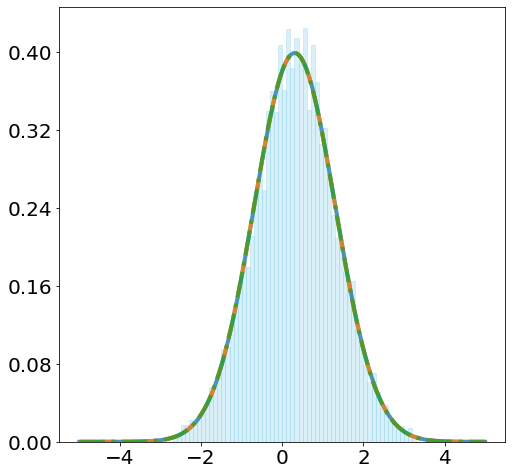

In [5]:
d_s = 1
d_a = 1

m = 1 # number of prior points
num_iid_samples = 10000

sigma = torch.ones(d_s)
norm_density = NonLDSDensity(d_s, sigma)
sm_estimator = ScoreMatching(norm_density)

# Define phi and thus v = W . phi, i.e. the mean of s'
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
s = torch.randn(m, d_s) + 0.5
a = torch.rand(m, d_a)
W = torch.Tensor([[0, 1]])

sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    norm_density, W, s, a, LDS_phi_embedding, num_iid_samples, 
    f'plots/1d_density__exp_fam_normal__{sampling_method}_smpl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=0.,
    MLE_use_normal_dist=False, MLE_all_priors_same=True,
    MLE_W0=torch.rand_like(W),
)

### Exp($\lambda$) RV

Calculating true density...
Calculating density using W_SM...
tvd_SM: 4.97479e-01
Calculating density using actual W_MLE...
tvd_actual_MLE: 2.53434e-02


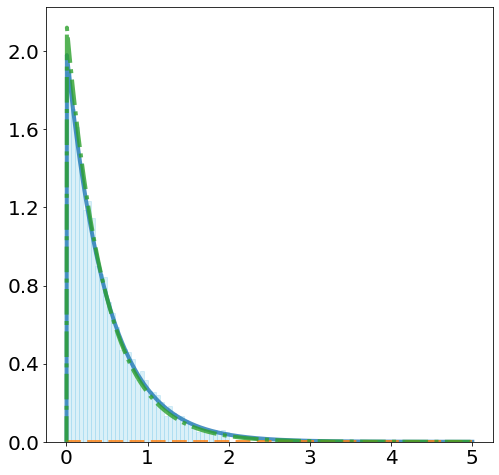

In [6]:
exp_density = ExpDensity(d_s)

m = 1
num_iid_samples = 10000

# to get parameter lambda, fix s and a to anything and make phi be ones everytime
lmb = 2.
const_one_phi_embedding = ConstPhiEmbedding(d_s, d_a, 1.)
s = torch.zeros(m, d_s) + 0.5
a = torch.zeros(m, d_a)
W = -lmb * torch.ones(exp_density.d_psi, const_one_phi_embedding.d_phi) # so Exp(2) random variable (W @ phi.T = -lambda)

sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    exp_density, W, s, a, const_one_phi_embedding, num_iid_samples,
    f'plots/1d_density__exp_fam_exp__{sampling_method}_sampl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=1e-2,
    MLE_use_normal_dist=False, MLE_all_priors_same=True
)

### Beta($\alpha, \beta$) RV

Calculating true density...
Calculating density using W_SM...
tvd_SM: 3.28749e-02
Calculating density using actual W_MLE...
tvd_actual_MLE: 2.94827e-02


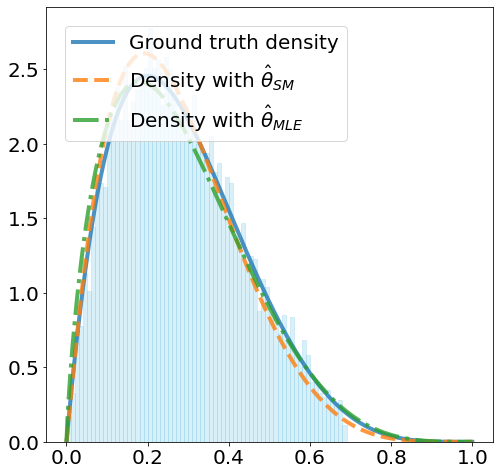

In [7]:
beta_density = BetaDensity(d_s)

m = 1
num_samples = 10000

# to get parameters alpha, beta, fix s and a to anything and make phi be ones everytime
alpha = 2.
beta = 5.
const_one_phi_embedding = ConstPhiEmbedding(d_s, d_a, 1.)
s = torch.zeros(m, d_s) + 0.5
a = torch.zeros(m, d_a) # place holder
W = torch.tensor([[alpha-1], [beta-1]]) # so Beta(alpha, beta) random variable (W @ phi.T = [alpha-1, beta-1])

sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    beta_density, W, s, a, const_one_phi_embedding, num_samples,
    f'plots/1d_density__exp_fam_beta__{sampling_method}_sampl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=1e-5,
    MLE_use_normal_dist=False,
    MLE_W0=torch.rand_like(W),
    show_legend=True,
)

### Custom Density

\begin{align*}
P_W (s' \mid s, a) &= q(s') \cdot \exp \left( \langle \psi(s'), W \phi(s, a) \rangle  - Z_{s, a}(W) \right) \text{ for } s' \in [-10, 20] \text{ and } P_W(s' \mid s, a) = 0 \text{ otherwise}\\
q(s') &= \exp \left( -\frac{||s'||^\alpha_\alpha}{\alpha}\right) \in \mathbb{R} \qquad \text{where } \alpha = 1.1\\
\psi(s') &= s' \in \mathbb{R}^{d_s}
\end{align*}

In [8]:
class CustomSinDensity(ExpGLMDensity):
    ALPHA = 1.7
    SUPPORT_LO = -6.
    SUPPORT_HI = 6.
    P = 4
    IS_PRODUCT_DENSITY = True

    def __init__(self, d_s: int):
        super(CustomSinDensity, self).__init__(
            d_s,
            use_scipy_integrate=False,
            integrate_lo=self.SUPPORT_LO,
            integrate_hi=self.SUPPORT_HI,
        )
        self.d_psi = self.d_s
        
    def __repr__(self) -> str:
        ALPHA = self.ALPHA
        P = self.P
        return f"$\\exp ( - \\frac{{ ||s'||_\\alpha^\\alpha }}{{ \\alpha }} ) \\cdot \\exp ( \\langle sin({P}s'), W \\phi(s, a) \\rangle - Z_{{s,a}}(W) )$\n$\\alpha={ALPHA:.1f}$"
    
    def in_support(self, x: T) -> torch.Tensor:
        return torch.all(
            torch.logical_and(x >= self.SUPPORT_LO, x <= self.SUPPORT_HI), dim=1
        )
    
    def psi(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        P = self.P
        psi = torch.sin(P*x)
        return psi
    
    def plot_psi(self):
        x = np.linspace(-5,5).reshape(50,1)
        plt.plot(x, self.psi(x))
        plt.show()
        
    def logq(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        ALPHA = self.ALPHA
        logq = - x.norm(p=ALPHA, dim=-1).pow(ALPHA) / ALPHA # shape (n)
        return logq

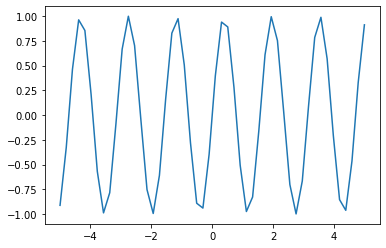

Calculating true density...
Calculating density using W_SM...
tvd_SM: 4.51194e-03
Calculating density using actual W_MLE...
tvd_actual_MLE: 3.64557e-03


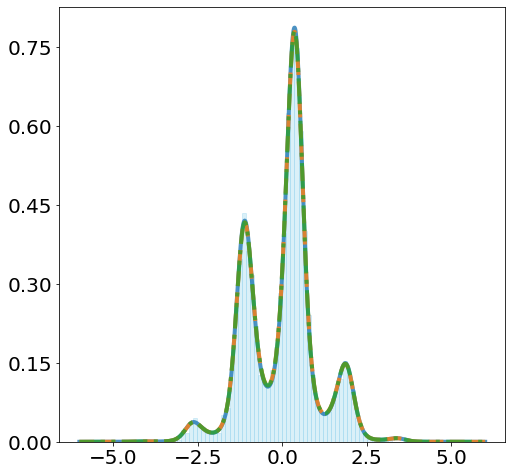

In [9]:
d_s = 1
d_a = 1

m = 1 # number of prior points
num_samples = 10000

# Init the score matching autograd class
# Since we know s' is gaussian, initialize the special class
custom_density = CustomSinDensity(d_s)

custom_density.plot_psi()

# Define phi and thus v = W . phi, i.e. the mean of s'
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
s = torch.zeros(m, d_s) + 2
a = torch.ones(m, d_a)
W = torch.Tensor([[0, 1]])

sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    custom_density, W, s, a, LDS_phi_embedding, num_samples,
    f'plots/1d_density__exp_fam_cust_sin__{sampling_method}_sampl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=1e-2,
    MLE_use_normal_dist=False,
    MLE_W0=torch.rand_like(W),
)

In [10]:
class CustomDensity(ExpGLMDensity):
    ALPHA = 2
    SUPPORT_LO = -8.
    SUPPORT_HI = 8.
    IS_PRODUCT_DENSITY = True

    def __init__(self, d_s: int):
        # Not using scipy integrate makes the density diverge
        super(CustomDensity, self).__init__(
            d_s,
            use_scipy_integrate=True,
        )
        self.d_psi = self.d_s
        
    def __repr__(self) -> str:
        ALPHA = CustomDensity.ALPHA
        return f"$\\exp ( - \\frac{{ ||s'||_\\alpha^\\alpha }}{{ \\alpha }} ) \\cdot \\exp ( \\langle sin^2(s'), W \\phi(s, a) \\rangle - Z_{{s,a}}(W) )$\n$\\alpha={ALPHA:.1f}$"
    
    def in_support(self, x: T) -> torch.Tensor:
        return torch.all(
            torch.logical_and(x >= self.SUPPORT_LO, x <= self.SUPPORT_HI), dim=1
        )
    
    def psi(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        psi = torch.sin(x)**2
        return psi
    
    def logq(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        ALPHA = self.ALPHA
        logq = - x.norm(p=ALPHA, dim=-1).pow(ALPHA) / ALPHA # shape (n)
        return logq


Calculating true density...
Calculating density using W_SM...
tvd_SM: 9.64575e-03
Calculating density using actual W_MLE...
tvd_actual_MLE: 1.18616e-02


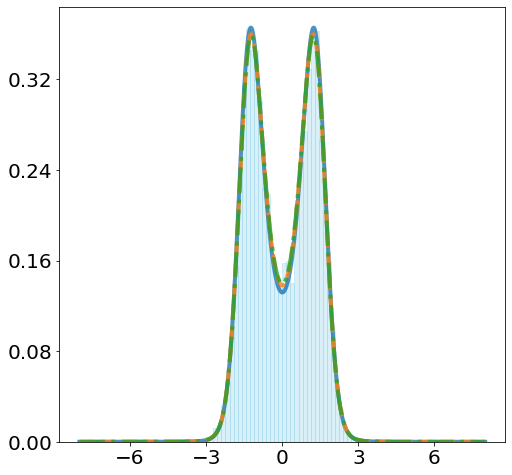

In [11]:
d_s = 1
d_a = 1

m = 1 # number of prior points
num_samples = 10000

# Init the score matching autograd class
# Since we know s' is gaussian, initialize the special class
custom_density = CustomDensity(d_s)

# Define phi and thus v = W . phi, i.e. the mean of s'
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
s = torch.zeros(m, d_s) + 2
a = torch.ones(m, d_a)*2
W = torch.Tensor([[0, 1]])

sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000,
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    custom_density, W, s, a, LDS_phi_embedding, num_samples,
    f'plots/1d_density__exp_fam_cust_sin_sq_x__{sampling_method}_sampl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=1e-2,
    MLE_use_normal_dist=False,
    MLE_W0=torch.rand_like(W),
)

Calculating true density...
Calculating density using W_SM...
tvd_SM: 7.06766e-04
Calculating density using actual W_MLE...
tvd_actual_MLE: 5.33938e-03


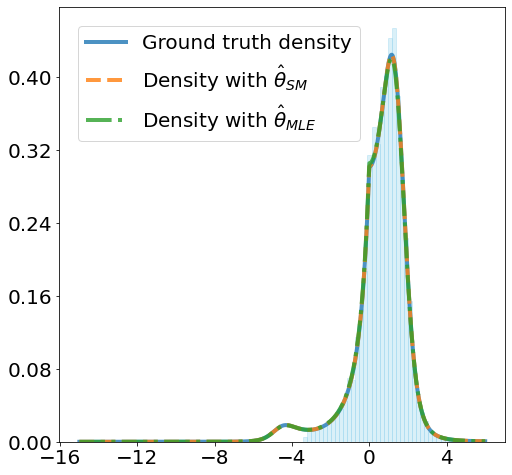

In [12]:
class CustomPolyDensity(CustomDensity):
    ALPHA = 1
    SUPPORT_LO = -15.
    SUPPORT_HI = 6.
    IS_PRODUCT_DENSITY = True

    def __init__(self, d_s: int):
        super(CustomDensity, self).__init__(d_s)
        self.d_psi = self.d_s
        
    def psi(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        psi = torch.exp(torch.sin(x))
        return psi

d_s = 1
d_a = 1

m = 1 # number of prior points
num_samples = 10000

# Init the score matching autograd class
# Since we know s' is gaussian, initialize the special class
custom_density = CustomPolyDensity(d_s)

# Define phi and thus v = W . phi, i.e. the mean of s'
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
s = torch.zeros(m, d_s) + 2
a = torch.ones(m, d_a)
W = torch.Tensor([[0, 1]])

sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    custom_density, W, s, a, LDS_phi_embedding, num_samples,
    f'plots/1d_density__exp_fam_cust_expsinx__{sampling_method}_sampl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=1e-2,
    MLE_use_normal_dist=False,
    MLE_W0=torch.rand_like(W),
    show_legend=True
)

tensor([[1.6167, 0.4488]]) tensor([[2.0655, 2.0655]])
Calculating true density...
Calculating density using W_SM...
tvd_SM: 9.64084e-03
Calculating density using actual W_MLE...


/home/anmolkabra/miniconda3/envs/rl-public/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:571: RuntimeWarning: invalid value encountered in subtract
  df = f2 - f1


tvd_actual_MLE: 8.61043e-02


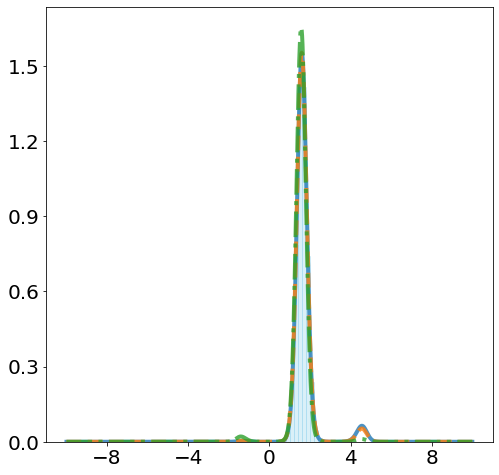

In [13]:
class CustomForMoGReLUDensity(ExpGLMDensity):
    ALPHA = 2
    SUPPORT_LO = -10.
    SUPPORT_HI = 10.
    IS_PRODUCT_DENSITY = True

    def __init__(
        self,
        d_s: int,
        sigma,
        use_scipy_integrate: bool = False,
        integrate_lo: float = -10.,
        integrate_hi: float = 10.,
        integrate_linspace_L: int = 1000,
    ):
        super(CustomForMoGReLUDensity, self).__init__(
            d_s, use_scipy_integrate=False,
        )
        self.sigma = utils.to_torch(sigma)
        self.d_psi = self.d_s * 2 # adding extra coordinates

    def __repr__(self) -> str:
        ALPHA = self.ALPHA
        sigma = self.sigma
        return f"$\\exp ( - \\frac{{ ||s'||_\\alpha^\\alpha }}{{ \\alpha \\cdot \\sigma }} ) \\cdot \\exp ( \\langle [s', relu(s')], W \\phi(s, a) \\rangle - Z_{{s,a}}(W) )$\n$\\alpha={ALPHA:.1f},\\sigma={sigma}$"

    def in_support(self, x: T) -> torch.Tensor:
        return torch.ones((x.shape[0]), dtype=bool)

    def psi(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        P = 1./self.sigma
        psi = torch.concat([x, 4*torch.sin(x)**2], dim=-1)
        return psi

    def logq(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        ALPHA = self.ALPHA
        # Weird issue of dimension collapse when sigma is 1d
        sigma = self.sigma.item() if self.sigma.shape[0] == 1 else self.sigma
        logq = - x.norm(p=ALPHA, dim=-1).pow(ALPHA) / (ALPHA) # shape (n)
        return logq

    def _inv_cdf__get_vji_tilde(
        self,
        v: torch.Tensor,
        j: int,
        i: int,
        inv_cdf_round_decimals: int,
    ) -> str:
        # For custom density, different sigma result in different
        # densities. So to differentiate densities with same v[j, i] but
        # different sigma, add sigma info to vji_tilde str
        sigma_str = f'sigma{self.sigma[i].item():.2e}'
        vji_tilde = ','.join(
            str(round(v[j, k].item(), inv_cdf_round_decimals))
            for k in range(v.shape[1])
        )
        vji_tilde = f'{sigma_str}_{vji_tilde}'
        return vji_tilde

d_s = 1
d_a = 1

m = 1 # number of prior points
num_samples = 10000

# Init the score matching autograd class
# Since we know s' is gaussian, initialize the special class
custom_density = CustomForMoGReLUDensity(d_s, sigma=(1.44e-02)*2.0)

# Define phi and thus v = W . phi, i.e. the mean of s'
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
s = torch.rand(m, d_s)*5.0 - 1
a = torch.rand(m, d_a)*0.5
W = torch.Tensor([[1, 1]]*custom_density.d_psi)

phi = LDS_phi_embedding.get_phi(s, a)
print(phi, phi @ W.T)
sampling_method = 'inv_cdf'
sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                   'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                   'inv_cdf_round_decimals': 2}
plot_1d_density(
    custom_density, W, s, a, LDS_phi_embedding, num_samples,
    f'plots/1d_density__exp_fam_cust_mog__{sampling_method}_sampl',
    sampling_method=sampling_method, sampling_kwargs=sampling_kwargs,
    SM_lam=1e-2,
    MLE_use_normal_dist=False,
    MLE_W0=torch.rand_like(W),
    # show_legend=True
)

### W, W_SM vs number of samples, TVD vs number of samples

In [14]:
def plot_param_recovery(
    exp_glm_density: ExpGLMDensity,
    W, s_gen, a_gen,
    phi_embedding: PhiEmbedding,
    method: str,
    m: int,
    num_samples: int,
    density_name: str = '$P(\\cdot)$',
    runs: int = 3,
    sampling_method: str = 'inv_cdf',
    sampling_kwargs: Dict[str, Any] = {'inv_cdf_linspace_L': 1000, 
                                       'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                                       'inv_cdf_round_decimals': 2},
    SM_lam: float = 0.,
    tvd_n_plot: int = 1000,
    fontsize: int = 16,
    ax: Optional[axes.Axes] = None,
) -> axes.Axes:
    assert method in ['iid', 'seq']
    d_s = exp_glm_density.d_s
    d_phi = phi_embedding.d_phi
    
    # Set up err matrices
    num_sm_estimates_per_run = 21
    total_num_samples = m*num_samples
    mns = np.logspace(
        np.log10(total_num_samples) / 2,
        np.log10(total_num_samples),
        num_sm_estimates_per_run,
        dtype=int
    )
    norm_errs_SM = np.zeros((num_sm_estimates_per_run, runs))
    norm_errs_MLE = np.zeros((runs)) # Using all sampled data in each random run
    if d_s == 1:
        # setup for tvd
        support_lo = -10 if np.isinf(exp_glm_density.SUPPORT_LO) and (exp_glm_density.SUPPORT_LO < 0) else exp_glm_density.SUPPORT_LO
        support_hi = 10 if np.isinf(exp_glm_density.SUPPORT_HI) and (exp_glm_density.SUPPORT_HI > 0) else exp_glm_density.SUPPORT_HI
        x = np.linspace(support_lo, support_hi, tvd_n_plot).reshape((-1, d_s)) # shape (tvd_n_plot, d_s)
        tvds_SM = np.zeros_like(norm_errs_SM)
        tvds_MLE = np.zeros_like(norm_errs_MLE)        
    
    sm_estimator = ScoreMatching(exp_glm_density)

    for i in tqdm(range(runs), desc='Random runs'):
        sampling_kwargs['sampling_seed'] = i
        
        if method == 'iid':
            s = s_gen(m, d_s)
            a = a_gen(m, d_a)
            # shape (m, num_samples, d_s), (m, d_phi)
            samples, phis = exp_glm_density.sample_iid(
                W, s, a, phi_embedding, num_samples, sampling_method, sampling_kwargs
            )
            
            samples_exp = samples.detach().reshape((-1, d_s)) # shape (m*num_samples, d_s)
            phis_exp = phis.unsqueeze(1).expand(-1, num_samples, -1).reshape((-1, d_phi)) # shape (m*num_samples, d_phi)
            first_phi = phis # shape (m, d_phi)

            if d_s == 1:
                prob = exp_glm_density.density(x, W, first_phi)

        elif method == 'seq':
            s = s_gen(m, d_s)
            a = a_gen(m, num_samples, d_a)

            # shape (m, num_samples, d_s), (m, num_samples, d_phi)
            samples, phis = exp_glm_density.sample_seq(
                W, s, a, phi_embedding, num_samples, sampling_method, sampling_kwargs
            )
            samples_exp = samples.detach().reshape((-1, d_s)) # shape (m*num_samples, d_s)
            phis_exp = phis.detach().reshape((-1, d_phi)) # shape (m*num_samples, d_phi)
            first_phi = phis[:, 0, :] # shape (m, d_phi)
            
            if d_s == 1:
                prob = exp_glm_density.density(x, W, first_phi)

        else:
            raise ValueError(f'sample_{method} not supported')
        
        # Get W_SM estimate using mn sampled points
        for j, mn in enumerate(mns):
            # Sample n points from phi and x
            sample_idxs = np.random.choice(total_num_samples, mn, replace=False)
            samples_j = samples_exp[sample_idxs, :] # shape (mn, d_s)
            phi_j = phis_exp[sample_idxs, :] # shape (mn, d_phi)

            W_SM = sm_estimator.W_estimate(samples_j, phi_j, lam=SM_lam, return_Vb_estimates=False)
            norm_errs_SM[j, i] = utils.to_numpy(torch.norm(W_SM - W, p='fro'))
        
            if d_s == 1:
                # TVD of estimate and true density
                prob_SM = exp_glm_density.density(x, W_SM, first_phi[:1, :]) # shape (tvd_n_plot, 1)
                tvds_SM[j, i] = utils.tvd(x[:, 0], utils.to_numpy(prob[:, 0]), utils.to_numpy(prob_SM[:, 0]))

    if ax is None:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(211)
    
    df = pd.DataFrame(data={
        'n': np.repeat(mns[:, np.newaxis], runs, axis=1).flatten(),
        density_name: norm_errs_SM.flatten(),
    })
    df2 = pd.melt(df, 'n', var_name='$f$runs', value_name='f')
    ax = sns.lineplot(x='n', y='f', hue='$f$runs', data=df2, ax=ax, linewidth=4)

    if d_s == 1:
        fig.set_size_inches(6, 8)
        
        # Plot tvd errs
        ax = fig.add_subplot(212)
    
        # Plot 1/sqrt(n) line
        ax.plot(mns, 1. / np.sqrt(mns), 'red', 
                label='$\\frac{{1}}{{ \\sqrt{{n}} }}$', linestyle='--', linewidth=4)

        # Plot norm errs vs ns with error region
        df = pd.DataFrame(data={
            'n': np.repeat(mns[:, np.newaxis], runs, axis=1).flatten(),
            '$tvd( P(\\cdot; \hat{{W}}_{{SM}}), P(\\cdot; W) )$': tvds_SM.flatten(),
        })
        df2 = pd.melt(df, 'n', var_name='$f$runs', value_name='f')
        sns.lineplot(x='n', y='f', hue='$f$runs', data=df2, ax=ax, linewidth=4)

        ax.set_xlabel('n', fontsize=fontsize)
        ax.set_ylabel('')
        ax.set(xscale='log', yscale='log')
        ax.legend(loc='best', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

    return ax

In [15]:
def calc_errs_param_recovery(
    exp_glm_density: ExpGLMDensity,
    W, s_gen, a_gen,
    phi_embedding: PhiEmbedding,
    method: str,
    m: int,
    num_samples: int,
    runs: int = 3,
    sampling_method: str = 'inv_cdf',
    sampling_kwargs: Dict[str, Any] = {'inv_cdf_linspace_L': 1000, 
                                       'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                                       'inv_cdf_round_decimals': 2},
    SM_lam: float = 0.,
):
    assert method in ['iid', 'seq']
    d_s = exp_glm_density.d_s
    d_phi = phi_embedding.d_phi
    
    # Set up err matrices
    num_sm_estimates_per_run = 21
    total_num_samples = m*num_samples
    mns = np.logspace(
        np.log10(total_num_samples) / 2,
        np.log10(total_num_samples),
        num_sm_estimates_per_run,
        dtype=int
    )
    norm_errs_SM = np.zeros((num_sm_estimates_per_run, runs))
    
    sm_estimator = ScoreMatching(exp_glm_density)
    for i in tqdm(range(runs), desc='Random runs'):
        sampling_kwargs['sampling_seed'] = i
        
        if method == 'iid':
            s = s_gen(m, d_s)
            a = a_gen(m, d_a)
            
            # shape (m, num_samples, d_s), (m, d_phi)
            samples, phis = exp_glm_density.sample_iid(
                W, s, a, phi_embedding, num_samples, sampling_method, sampling_kwargs
            )
            
            samples_exp = samples.detach().reshape((-1, d_s)) # shape (m*num_samples, d_s)
            phis_exp = phis.unsqueeze(1).expand(-1, num_samples, -1).reshape((-1, d_phi)) # shape (m*num_samples, d_phi)

        elif method == 'seq':
            s = s_gen(m, d_s)
            a = a_gen(m, num_samples, d_a)
            
            # shape (m, num_samples, d_s), (m, num_samples, d_phi)
            samples, phis = exp_glm_density.sample_seq(
                W, s, a, phi_embedding, num_samples, sampling_method, sampling_kwargs
            )
            samples_exp = samples.detach().reshape((-1, d_s)) # shape (m*num_samples, d_s)
            phis_exp = phis.detach().reshape((-1, d_phi)) # shape (m*num_samples, d_phi)
            first_phi = phis[:, 0, :] # shape (m, d_phi)
            
        else:
            raise ValueError('sample_{method} not supported')
        
        # Get W_SM estimate using mn sampled points
        for j, mn in enumerate(mns):
            # Sample n points from phi and x
            sample_idxs = np.random.choice(total_num_samples, mn, replace=False)
            samples_j = samples_exp[sample_idxs, :] # shape (mn, d_s)
            phi_j = phis_exp[sample_idxs, :] # shape (mn, d_phi)

            W_SM = sm_estimator.W_estimate(samples_j, phi_j, lam=SM_lam, return_Vb_estimates=False)
            norm_errs_SM[j, i] = utils.to_numpy(torch.norm(W_SM - W, p='fro'))
        
    return mns, norm_errs_SM

In [16]:
class CustomDensityFullSupport(CustomDensity):
    SUPPORT_LO = -np.inf
    SUPPORT_HI = np.inf
    
    def __init__(self, d_s: int):
        super(CustomDensityFullSupport, self).__init__(d_s)


class CustomSinDensityFullSupport(CustomSinDensity):
    SUPPORT_LO = -np.inf
    SUPPORT_HI = np.inf
    
    def __init__(self, d_s: int):
        super(CustomSinDensityFullSupport, self).__init__(d_s)

class CustomForMoGReLUDensityFullSupport(CustomForMoGReLUDensity):
    SUPPORT_LO = -np.inf
    SUPPORT_HI = np.inf
    
    def __init__(self, d_s: int, sigma):
        super(CustomForMoGReLUDensityFullSupport, self).__init__(d_s, sigma)

In [17]:
# Initializing dicts here allows persistence on multiple runs of sampling
norm_density_sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                                'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                                'inv_cdf_round_decimals': 2}
custom_density_sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                                  'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                                  'inv_cdf_round_decimals': 2}
custom_sin_density_sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                                      'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                                      'inv_cdf_round_decimals': 2}
custom_mog_sampling_kwargs = {'inv_cdf_linspace_L': 1000, 
                              'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
                              'inv_cdf_round_decimals': 2}

* iid sampling
** Normal density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.59it/s]


** Custom MOG Density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.79it/s]


** Custom Density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.09s/it]


** Custom Sin Density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.77it/s]


* seq sampling
** Normal density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


** Custom MOG Density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


** Custom Density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.68s/it]


** Custom Sin Density


Random runs: 100%|█████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


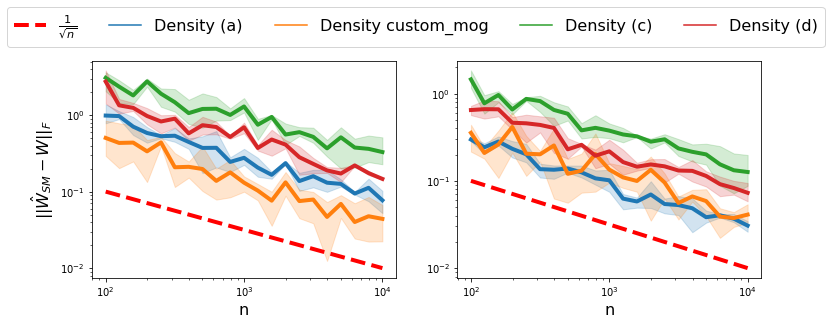

In [18]:
runs = 3
SM_lam = 1e-5
d_s = 3
d_a = 1

m = 100
num_samples = 100
def s_gen(m, d_s):
    return torch.rand(m, d_s) + 0.5
def seq_a_gen(m, num_samples, d_a):
    return torch.randn(m, num_samples, d_a)
def iid_a_gen(m, d_a):
    return torch.randn(m, d_a)
a_gen = {'iid': iid_a_gen, 'seq': seq_a_gen}

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fontsize = 16

sampling_method = 'inv_cdf'
for ax, process in zip(axs, ['iid', 'seq']):
    print(f'* {process} sampling')
    print('** Normal density')
    sigma = torch.ones(d_s)
    density = NonLDSDensity(d_s, sigma)
    LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
    # W = torch.rand(density.d_psi, LDS_phi_embedding.d_phi) # shape (d_psi, d_phi)
    W = torch.Tensor([[0]*d_s + [1]*d_a]*density.d_psi) # shape (d_psi, d_phi)

    mns, norm_errs_SM__normal = calc_errs_param_recovery(
        density, W, s_gen, a_gen[process], LDS_phi_embedding, process, m, num_samples, runs=runs, SM_lam=SM_lam, 
        sampling_method=sampling_method, sampling_kwargs=norm_density_sampling_kwargs,
    )

    print('** Custom MOG Density')
    sigma = torch.ones(1)
    density = CustomForMoGReLUDensityFullSupport(1, sigma=sigma)
    # W = torch.rand(density.d_psi, LDS_phi_embedding.d_phi) # shape (d_psi, d_phi)
    W = torch.Tensor([[0]*1 + [1]*d_a]*density.d_psi) # shape (d_psi, d_phi)
    phi_em = LDSPhiEmbedding(1, d_a)

    mns, norm_errs_SM__custom_mog = calc_errs_param_recovery(
        density, W, s_gen, a_gen[process], phi_em, process, m, num_samples, runs=runs, SM_lam=1., 
        sampling_method=sampling_method, sampling_kwargs=custom_density_sampling_kwargs,
    )
    
    print('** Custom Density')
    density = CustomDensityFullSupport(d_s)
    # W = torch.rand(density.d_psi, LDS_phi_embedding.d_phi) # shape (d_psi, d_phi)
    W = torch.Tensor([[0]*d_s + [1]*d_a]*density.d_psi) # shape (d_psi, d_phi)

    mns, norm_errs_SM__custom = calc_errs_param_recovery(
        density, W, s_gen, a_gen[process], LDS_phi_embedding, process, m, num_samples, runs=runs, SM_lam=SM_lam, 
        sampling_method=sampling_method, sampling_kwargs=custom_density_sampling_kwargs,
    )

    print('** Custom Sin Density')
    density = CustomSinDensity(d_s)
    # W = torch.rand(density.d_psi, LDS_phi_embedding.d_phi) # shape (d_psi, d_phi)
    W = torch.Tensor([[0]*d_s + [1]*d_a]*density.d_psi) # shape (d_psi, d_phi)

    mns, norm_errs_SM__custom_sin = calc_errs_param_recovery(
        density, W, s_gen, a_gen[process], LDS_phi_embedding, process, m, num_samples, runs=runs, SM_lam=SM_lam, 
        sampling_method=sampling_method, sampling_kwargs=custom_sin_density_sampling_kwargs,
    )

    # Plot 1/sqrt(n) line
    ax.plot(mns, 1. / np.sqrt(mns), 'red',
            label='$\\frac{{1}}{{ \\sqrt{{n}} }}$', linestyle='--', linewidth=4)

    # Plot norm errs
    df = pd.DataFrame(data={
        'n': np.repeat(mns[:, np.newaxis], runs, axis=1).flatten(),
        'Density (a)': norm_errs_SM__normal.flatten(),
        'Density custom_mog': norm_errs_SM__custom_mog.flatten(),
        'Density (c)': norm_errs_SM__custom.flatten(),
        'Density (d)': norm_errs_SM__custom_sin.flatten(),
    })
    df2 = pd.melt(df, 'n', var_name='$f$runs', value_name='f')
    g = sns.lineplot(x='n', y='f', hue='$f$runs', data=df2, ax=ax, linewidth=4)
    g.get_legend().remove()

    # Plot formatting
    ax.set_xlabel('n', fontsize=fontsize)
    ax.set_ylabel('')
    ax.set(xscale='log', yscale='log')

# Fix legend at bottom
axs[0].set_ylabel('$|| \hat{{W}}_{{SM}} - W ||_F$', fontsize=fontsize)
handles0, labels0 = axs[0].get_legend_handles_labels()
fig.legend(handles0, labels0, loc='lower center',
           fontsize=fontsize, bbox_to_anchor=(0.5, 0.9), ncol=len(handles0))

plot_save_path = f'plots/{sampling_method}__norm_err_scaling_with_n_combined'
plt.savefig(f'{plot_save_path}.png', bbox_inches='tight')
plt.savefig(f'{plot_save_path}.pdf', bbox_inches='tight')
plt.show()